## Script of the model



In [14]:
#1. IMPORTING PACKAGES AND LIBRARIES
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.img_tiles import OSM
from cartopy.io.img_tiles import GoogleTiles as moa
from cycler import cycler
import scipy
import seaborn as sns

import glob
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import pyproj
import osr
import datetime
import subprocess
import shutil
import numpy as np
from ipywidgets import interact
import pandas as pd
import pickle
from scipy.signal import savgol_filter
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot


#own libary
import nsidc



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
#SELECT BOUNDS AND START / END DATES
bounds = [( -19., 20.),
          (-11., 27.),
         ]

# start_date = datetim.datetime(2002, 5, 29) # Start of the AMSR-E period
# start_date = datetime.datetime(2004, 1, 1) # date after data recovery
# end_date = datetime.datetime(2009, 12, 31)  # only a few days to make a demonstration
# end_date = datetime.datetime(2004, 6, 30)  # use this end date to cover the whole AMSR-E period.
# end_date = datetime.datetime(2002, 1, 2)

#---------------------------#---------------------------#---------------------------#---------------------------#

#Select set of POI's to use

# points = pd.read_csv('poizambeziplain.csv')   #Kalabo (weinig goede resultaten)
points = pd.read_csv('poi_senaga.csv')
# points = pd.read_csv('POIs_LI.csv')
# points = pd.read_csv('POIs_RE_3p.csv')


#adjust according to number of points in POI's
points_interest = [(points.xcoord[0],points.ycoord[0]),
                   (points.xcoord[1],points.ycoord[1])]
#                    (points.xcoord[2],points.ycoord[2]),
#                    (points.xcoord[3],points.ycoord[3]),
#                    (points.xcoord[4],points.ycoord[4])]
#                    (points.xcoord[5],points.ycoord[5])]
#                    (points.xcoord[6],points.ycoord[6]) 


# Download discharge data, no adjustment 
# dQ = pd.read_csv('ZAMBEZIDISCHARGE.csv',sep=';',parse_dates=['DATE'],index_col = ['DATE'],na_filter=True)
dQ = pd.read_csv('ZAMBEZIDISCHARGE.csv',sep=';',na_filter=True) #,parse_dates=['DATE'],index_col = ['DATE']
dQ['Date'] = pd.to_datetime(dQ['Date'])


rollingvalue =1
#---------------------------#---------------------------#---------------------------#---------------------------#

# DOWNLOAD THE CORRECT DATA
# This cell calls the right download and "glues" the years together. 

fns=None


year = 2002  #change year to select specific year to see [2002-2011]

# 25 km resolution PMSR DATA
# fns = glob.glob(f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/NSIDC_Test_{year}.nc')
#select this next one for full period data string (whole AMSR period)
# fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/*.nc') # select this line to get the whole AMSR-E period
#DMSP
fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/DMSP/*.nc') # select this line to get the whole AMSR-E period

SAT='DSMP'
# SAT='AMSRE'

# 3.125 km resolution PMSR DATA

# fns = glob.glob(f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/3km36ghz/NSIDC_Test_{year}.nc')
#select this next one for full period data string (whole AMSR period)
# fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/3km36ghz/*.nc') # select this line to get the whole AMSR-E period




fns.sort()
ds = xr.open_mfdataset(fns)


#---------------------------#---------------------------#---------------------------#---------------------------#

# Discharge data location
# location = 'Kalabo'  
location = 'Senanga'
# location = 'Lukulu'


#---------------------------#---------------------------#---------------------------#---------------------------#


# TRANSFORMING, NO ADJUSTMENT NEEDED
proj4str = '+proj=cea +lat_0=0 +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m'
# we define a projection object for lat-lon WGS84 (EPSG code 4326)
proj_out = pyproj.Proj(init='epsg:4326')
# we define a projection object for the projection used in the downloaded grids.
proj_in = pyproj.Proj(proj4str)

# here we convert the coordinates in lat-lon into the coordinate system of the downloaded grids.
bounds_xy = nsidc.proj_coords(bounds, proj_out, proj_in)
points_xy = nsidc.proj_coords(points_interest, proj_out, proj_in)
points_x, points_y = zip(*points_xy)

#---------------------------#---------------------------#---------------------------#---------------------------#




<ipython-input-26-0c1c8a7a6a1e>:69: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds = xr.open_mfdataset(fns)
/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/xarray/backends/api.py:926: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(
/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/pyproj/crs.py:77: Fu

In [19]:
from functions_pmrs import loadCM
df = loadCM(points_xy,ds, rollingvalue)
plt.figure(figsize=(19,7))
plt.plot(df)

KeyboardInterrupt: 

In [ ]:

# plotting the data at Lukulu
import nsidc

fig, ax = plt.subplots(figsize=(15,5))
sns.set()

first_threshold_exceedance = {}

df = pd.DataFrame()

for n in [x for x in range(2)]: 
    C, M, ratio,  = nsidc.c_m_ratio(ds['TB'], x, y)
    
    df[n] = ratio
    dates = ratio.time.values
    df.index=dates
    
    
    
    df[n].fillna(method='bfill',inplace=True)
    df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)
    df[n] = df[n].rolling(6,center=False).median()  # apply and set the rolling median to 6
    
    trigger = df.quantile([0.9, 0.95, 0.98])
#     fte =trigger[n][0.95]

    if n==0:
        df[0]=df[0].shift(shift)   

    ax.plot(df[n] ,marker='.', markersize=1.2,label= (f'CM ratio at POI{n}- rolling median of 6'))
    first_threshold_exceedance [n] = df[n][df[n] > 1.05].first_valid_index()
    


# plt.axhline(y=trigger[2][0.9],linewidth=0.8, color='r',label = 'trigger 90% percentile')    
# plt.axhline(y=trigger[2][0.95],linewidth=0.8, color='r',label = 'trigger 95% percentile')
# plt.axhline(y=trigger[2][0.98],linewidth=0.8, color='r',label = 'trigger 98% percentile')
# # plt.axvline(x=(1*30.5),linewidth=0.5, color='r')
# plt.axvline(x=(4*30.5),linewidth=0.5, color='r')
  
    

df.index=dates
df.columns = ['POI0', 'POI2'] #,'POI2','POI3','POI4']
df.head()

    
ax.set(xlabel='Years of ASMR-E dataset', ylabel='CM Ratio (-)',
       title=f' CM Ratio at the selected locations for Lukulu given LT = {shift}')
ax.tick_params(labelsize=12)
ax.grid(b=bool)

plt.legend()

plt.legend()

# plt.axhline(y=1.05,linewidth=0.5, color='r')
# # plt.axvline(x=70,linewidth=0.5, color='r')
# plt.axvline(x=(1*30.5),linewidth=0.5, color='r')
# plt.axvline(x=(5*30.5),linewidth=0.5, color='r')
#     plt.axvline(x=120,linewidth=0.5, color='r')
plt.grid(b=bool,which='major')


# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/Model Runs/{location}_LT({shift})_1CM_POIs_25km.png'),dpi=600)
plt.show()

In [ ]:
df

In [ ]:
df.POI0.fillna(1, inplace=True)
df.POI2.fillna(1, inplace=True)

x_set = df['POI0']

df= df[df.index.month<5]



model = smf.quantreg('POI2 ~ POI0', df)
quantiles = [0.05, 0.10, 0.90 , 0.95, 0.50]
fits = [model.fit(q=q) for q in quantiles]
figure, axes = plt.subplots(figsize=(10,10))

x = df['POI0']
y = df['POI2']

fit = np.polyfit(x, y, deg=1)
_x = np.linspace(x.min(), x.max(), num=len(y))

res = model.fit(q=.5)
print(res.summary())


# fit lines
_y_005 = fits[0].params['POI0'] * _x + fits[0].params['Intercept']
_y_095 = fits[3].params['POI0'] * _x + fits[3].params['Intercept']
_y_010 = fits[1].params['POI0'] * _x + fits[1].params['Intercept']
_y_090 = fits[2].params['POI0'] * _x + fits[2].params['Intercept']
_y_050 = fits[4].params['POI0'] * _x + fits[4].params['Intercept']

# start and end coordinates of fit lines
p = np.column_stack((x, y))
a = np.array([_x[0], _y_005[0]]) #first point of 0.05 quantile fit line
b = np.array([_x[-1], _y_005[-1]]) #last point of 0.05 quantile fit line

a_ = np.array([_x[0], _y_095[0]])
b_ = np.array([_x[-1], _y_095[-1]])

a__ = np.array([_x[0], _y_010[0]]) #first point of 0.10 quantile fit line
b__ = np.array([_x[-1], _y_010[-1]]) #last point of 0.10 quantile fit line

a___ = np.array([_x[0], _y_090[0]])
b___ = np.array([_x[-1], _y_090[-1]])



#mask based on if coordinates are above 0.95 or below 0.05 quantile fitlines using cross product

mask = lambda p, a, b, a_, b_: (np.cross(p-a, b-a) > 0) | (np.cross(p-a_, b_-a_) < 0)
mask = mask(p, a, b, a_, b_)

axes.scatter(x[mask], df['POI2'][mask], facecolor='r', edgecolor='none', alpha=0.3, label='data point outside outer quantiles')
axes.scatter(x[~mask], df['POI2'][~mask], facecolor='g', edgecolor='none', alpha=0.3, label='data point inside outer quantiles')

axes.plot(x, fit[0] * x + fit[1], label='best-fit', c='grey')
axes.plot(_x, _y_095, label=quantiles[0], c='red')
axes.plot(_x, _y_005, label=quantiles[3], c='red')
axes.plot(_x, _y_090, label=quantiles[1], c='orange')
axes.plot(_x, _y_010, label=quantiles[2], c='orange')

axes.legend()
axes.set_title(f'Quantile Regression function Lukulu given LT = {shift}')
axes.set_xlabel('POI0 (upstream) - CM RATIO (-)')
axes.set_ylabel('POI2 (downstream) - CM RATIO (-)')
axes.text(1.04,0.98, f'R-squared = %0.3f' %res.prsquared,fontsize =14)


# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/Model Runs/{location}_LT({shift})_2QR.png'),dpi=600)



plt.show()



In [ ]:
_y_005 = fits[0].params['POI0'] * x_set + fits[0].params['Intercept']
_y_095 = fits[3].params['POI0'] * x_set + fits[3].params['Intercept']
_y_010 = fits[1].params['POI0'] * x_set + fits[1].params['Intercept']
_y_090 = fits[2].params['POI0'] * x_set + fits[2].params['Intercept']
_y_050 = fits[4].params['POI0'] * x_set + fits[4].params['Intercept']

x_date = _y_050.reset_index().values[:,0]
y50 = _y_050.reset_index().values[:,1].astype(float)
y10 = _y_010.reset_index().values[:,1].astype(float)
y05 = _y_005.reset_index().values[:,1].astype(float)
y90 = _y_090.reset_index().values[:,1].astype(float)
y95 = _y_095.reset_index().values[:,1].astype(float)

y50 = np.array([y50[i] for i in range (0,len(y50))])
y10 = np.array([y10[i] for i in range (0,len(y10))])
y05 = np.array([y05[i] for i in range (0,len(y05))])
y90 = np.array([y90[i] for i in range (0,len(y90))])
y95 = np.array([y95[i] for i in range (0,len(y95))])


fig, ax = plt.subplots(figsize=(17,7))


ax.fill_between(x_date, y05, y10, alpha =0.3,linewidth =0.0, color='tab:grey',label='95% probability function')
ax.fill_between(x_date, y10, y90, alpha =0.6,linewidth =0.0, color='tab:grey',label='90%-10% probability function')
ax.fill_between(x_date, y90, y95, alpha =0.3,linewidth =0.0 ,color='tab:grey',label='5% probability function')
ax.plot(x_date,y50,'r',alpha =1,linestyle='dashed',label='50% probability function')
ax.set(xlabel='Years of ASMR-E dataset', ylabel='CM Ratio (-)',
       title=f'Lukulu - Probability of Exceedance given LT = {shift}')
ax.legend(fancybox=True, framealpha=0.5)
ax.tick_params(labelsize=12)
ax.grid(b=bool)


# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/Model Runs/{location}_LT({shift})_3PropOfExc.png'),dpi=600)




In [24]:
plot=0
shift=0
rollingvalue =1
selection=6 # < number of months to be choosen
# month =5
windowlength=15
polyorder=1

from functions_pmrs import loadCM
from functions_pmrs import loadCMSAV
from functions_pmrs import applyshift
from functions_pmrs import calculateQR
from functions_pmrs import NQT
from functions_pmrs import probability



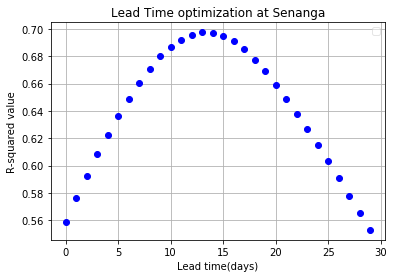

In [27]:

for n in range (30):
    shift =n
#     df = loadCM(points_xy,ds, rollingvalue)
    df = loadCMSAV(points_xy, ds, windowlength, polyorder)

    df = applyshift(df,rollingvalue,shift,plot,SAT)
#     df_nqt = NQT(df,plot, shift, location, rollingvalue)
    fits,res = calculateQR(df,selection,plot,shift,location)
#     y50 = probability(df, fits, plot, shift,location)
    
    plt.plot(shift,res.prsquared,'o',linewidth=4, markersize=6,color='b')
    
    plt.title(f'Lead Time optimization at {location}')
    plt.legend(fancybox=True, framealpha=0.5)
    plt.xlabel('Lead time(days)')
    plt.ylabel('R-squared value')
    plt.grid(b='bool')
    
# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/ShiftOptimization{location}{SAT}.png'),dpi=600)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


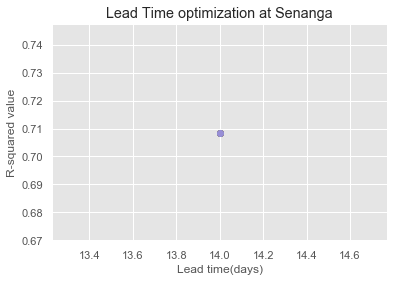

In [29]:
for i in range(9,21,2):
    windowlength = 21 
    for m in range(1,7,2):
        polyorder = 1
        
        for n in range (20):
            shift =14
#     df = loadCM(points_xy,ds, rollingvalue)
            df = loadCMSAV(points_xy, ds, windowlength, polyorder)

            df = applyshift(df,rollingvalue,shift,plot,SAT)
#     df_nqt = NQT(df,plot, shift, location, rollingvalue)
            fits,res = calculateQR(df,selection,plot,shift,location)
#     y50 = probability(df, fits, plot, shift,location)
    
            plt.plot(shift,res.prsquared,'o',linewidth=4, markersize=6)
    
            plt.title(f'Lead Time optimization at {location}')
            plt.legend(fancybox=True, framealpha=0.5)
            plt.xlabel('Lead time(days)')
            plt.ylabel('R-squared value')
            plt.grid(b='bool')
    
# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/ShiftOptimization{location}{SAT}.png'),dpi=600)


In [27]:
shift=0
rollingvalue =6
selection=5 # < number of months to be choosen
plot =0
month =5
SAT
res.prsquared

0.6989480744277535

/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)
No handles with labels found to put in legend.
/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)
No handles with labels found to put in legend.
/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - 

No handles with labels found to put in legend.
/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)
No handles with labels found to put in legend.
/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)
No handles with labels found to put in legend.


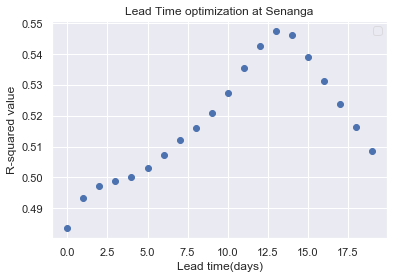

In [8]:
# plotting the data at Senanga
import nsidc
from functions_pmrs import loadCM
from functions_pmrs import applyshift
from functions_pmrs import calculateQR
from functions_pmrs import probability



for n in range (20):
    shift = n
    plot=0
    df = loadCM(points_xy,ds, rollingvalue)

    df = applyshift(df,rollingvalue,shift,plot,SAT)

    fits,res = calculateQR(df,selection,plot,shift,location)

#     y50 = probability(df, fits, plot, shift)


    

    plt.plot(shift,res.prsquared,'o',linewidth=4, markersize=6,color='b')

    plt.title(f'Lead Time optimization at Senanga')
    plt.legend(fancybox=True, framealpha=0.5)
    plt.xlabel('Lead time(days)')
    plt.ylabel('R-squared value')
    plt.grid(b='bool')

# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/Model Runs/{location}_LT({shift})_1CM_POIs_25km.png'),dpi=600)


In [26]:

# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/Model Runs/{location}_LT({shift})_2QR.png'),dpi=600)


In [85]:
shift

2

                         QuantReg Regression Results                          
Dep. Variable:                   POI4   Pseudo R-squared:               0.6374
Model:                       QuantReg   Bandwidth:                    0.003788
Method:                 Least Squares   Sparsity:                      0.02256
Date:                Thu, 05 Mar 2020   No. Observations:                 2922
Time:                        13:04:16   Df Residuals:                     2920
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0361      0.005      7.334      0.000       0.026       0.046
POI1           0.9553      0.005    203.991      0.000       0.946       0.964


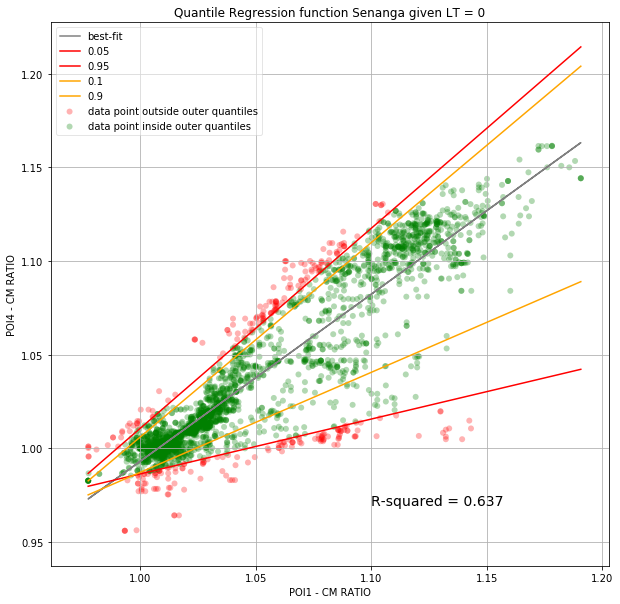

In [29]:

# QR plot of the Dataframe


x_set = df['POI1']

df= df[df.index.month<month] #select only the months in the rainy season to look at the effects of the CM ratio for inundation. 



model = smf.quantreg('POI4 ~ POI1', df) #call the model
quantiles = [0.05, 0.10, 0.90 , 0.95, 0.50]
fits = [model.fit(q=q) for q in quantiles]
figure, axes = plt.subplots(figsize=(10,10))

x = df['POI1']

y = df['POI4']

fit = np.polyfit(x, y, deg=1)
_x = np.linspace(x.min(), x.max(), num=len(y))

res = model.fit(q=0.5)
print(res.summary())




# fit lines
_y_005 = fits[0].params['POI1'] * _x + fits[0].params['Intercept']
_y_095 = fits[3].params['POI1'] * _x + fits[3].params['Intercept']
_y_010 = fits[1].params['POI1'] * _x + fits[1].params['Intercept']
_y_090 = fits[2].params['POI1'] * _x + fits[2].params['Intercept']
_y_050 = fits[4].params['POI1'] * _x + fits[4].params['Intercept']


# start and end coordinates of fit lines
p = np.column_stack((x, y))
a = np.array([_x[0], _y_005[0]]) #first point of 0.05 quantile fit line
b = np.array([_x[-1], _y_005[-1]]) #last point of 0.05 quantile fit line

a_ = np.array([_x[0], _y_095[0]])
b_ = np.array([_x[-1], _y_095[-1]])

a__ = np.array([_x[0], _y_010[0]]) #first point of 0.10 quantile fit line
b__ = np.array([_x[-1], _y_010[-1]]) #last point of 0.10 quantile fit line

a___ = np.array([_x[0], _y_090[0]])
b___ = np.array([_x[-1], _y_090[-1]])



#mask based on if coordinates are above 0.95 or below 0.05 quantile fitlines using cross product

mask = lambda p, a, b, a_, b_: (np.cross(p-a, b-a) > 0) | (np.cross(p-a_, b_-a_) < 0)
mask = mask(p, a, b, a_, b_)

axes.scatter(x[mask], df['POI4'][mask], facecolor='r', edgecolor='none', alpha=0.3, label='data point outside outer quantiles')
axes.scatter(x[~mask], df['POI4'][~mask], facecolor='g', edgecolor='none', alpha=0.3, label='data point inside outer quantiles')

axes.plot(x, fit[0] * x + fit[1], label='best-fit', c='grey')
axes.plot(_x, _y_095, label=quantiles[0], c='red')
axes.plot(_x, _y_005, label=quantiles[3], c='red')
axes.plot(_x, _y_090, label=quantiles[1], c='orange')
axes.plot(_x, _y_010, label=quantiles[2], c='orange')

axes.set_title(f'Quantile Regression function Senanga given LT = {shift}')
axes.legend(fancybox=True, framealpha=0.5)
axes.set_xlabel('POI1 - CM RATIO')
axes.set_ylabel('POI4 - CM RATIO')
axes.text(1.10,0.97, f'R-squared = %0.3f' %res.prsquared,fontsize =14)
axes.grid(b='bool')

# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/Model Runs/{location}_LT({shift})_2QR.png'),dpi=600)

plt.show()




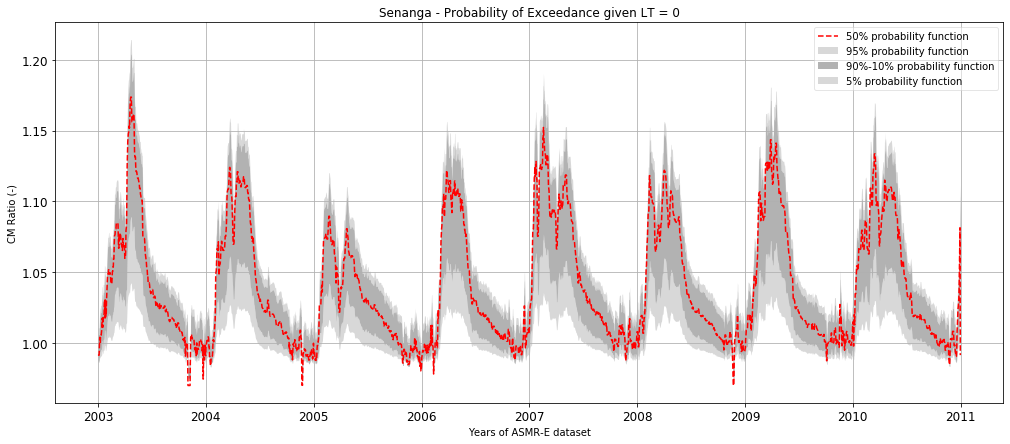

In [30]:
_y_005 = fits[0].params['POI1'] * x_set + fits[0].params['Intercept']
_y_095 = fits[3].params['POI1'] * x_set + fits[3].params['Intercept']
_y_010 = fits[1].params['POI1'] * x_set + fits[1].params['Intercept']
_y_090 = fits[2].params['POI1'] * x_set + fits[2].params['Intercept']
_y_050 = fits[4].params['POI1'] * x_set + fits[4].params['Intercept']

x_date = _y_050.reset_index().values[:,0]
y50 = _y_050.reset_index().values[:,1].astype(float)
y10 = _y_010.reset_index().values[:,1].astype(float)
y05 = _y_005.reset_index().values[:,1].astype(float)
y90 = _y_090.reset_index().values[:,1].astype(float)
y95 = _y_095.reset_index().values[:,1].astype(float)

y50 = np.array([y50[i] for i in range (0,len(y50))])
y10 = np.array([y10[i] for i in range (0,len(y10))])
y05 = np.array([y05[i] for i in range (0,len(y05))])
y90 = np.array([y90[i] for i in range (0,len(y90))])
y95 = np.array([y95[i] for i in range (0,len(y95))])


fig, ax = plt.subplots(figsize=(17,7))


ax.fill_between(x_date, y05, y10, alpha =0.3,linewidth =0.0, color='tab:grey',label='95% probability function')
ax.fill_between(x_date, y10, y90, alpha =0.6,linewidth =0.0, color='tab:grey',label='90%-10% probability function')
ax.fill_between(x_date, y90, y95, alpha =0.3,linewidth =0.0 ,color='tab:grey',label='5% probability function')
ax.plot(x_date,y50,'r',alpha =1,linestyle='dashed',label='50% probability function')
ax.set(xlabel='Years of ASMR-E dataset', ylabel='CM Ratio (-)',
       title=f'Senanga - Probability of Exceedance given LT = {shift}')
ax.legend(fancybox=True, framealpha=0.5)
ax.tick_params(labelsize=12)
ax.grid(b=bool)


# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/Model Runs/{location}_LT({shift})_3PropOfExc.png'),dpi=600)


In [46]:
test_xvalue =np.arange(0, 20, 0.5)

obs = df.POI1.replace(df.POI1[:],df.POI1.max()*0.93)
pred = df.POI4

output =calc_performance_scores(obs,pred)
output

<ipython-input-32-f0a0ac2f92fa>:9: RuntimeWarning: invalid value encountered in long_scalars
  output['pod'] = hits / (hits + misses) #Probability of Detection


pod     NaN
far     1.0
pofd    1.0
csi     0.0
dtype: float64

## Function to compute confusion matrix (hits, false alarms, misses, correct negatives) and performance indexes (FAR, POD, POFD, CSI))



Methodology adapted taking into account the consecutive day above thresholds as a unique flood period

hits:              Number of peak period above thresholds that have at least one observation day within the period

false alarm :      number of peak above threshold(consecutive day above discharge threshold as an event), minus the number of hits

misses :           number of observed flood events no in a discharge peak period  above threshold

correct negative : forcing the correct negative number to be the same than the number of observed flood events (misses + hits)




In [32]:
def calc_performance_scores(obs, pred):
    df= pd.DataFrame({'cons_class': pred.diff().ne(0).cumsum(), 'hits':(obs==1) & (pred ==1)})
    hits= df[['cons_class','hits' ]].drop_duplicates().hits[df.hits == True].count()
    false_al = (pred.loc[pred.shift() != pred].sum ()) - hits 
    misses = sum((obs == 1) & (pred ==0))
    corr_neg = misses + hits
    
    output = {}
    output['pod'] = hits / (hits + misses) #Probability of Detection
    output['far'] = false_al / (hits + false_al) #False Alarm Rate
    output['pofd'] = false_al / (false_al + corr_neg) #Probability of fase detection
    output['csi'] = hits / (hits + false_al + misses) #Critical succes index
    
    output = pd.Series(output)
    return output

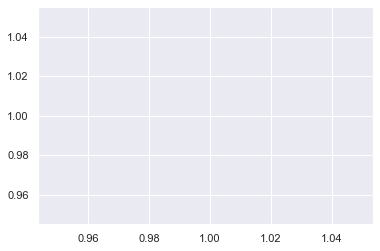

In [391]:
plt.plot(output['far'],output['pod'])

In [ ]:
from sklearn import preprocessing


df_temp = np.sort(df,axis=1)
# df_temp
quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal',copy=True)


X_trans = quantile_transformer.fit_transform(df_temp)
X_trans = quantile_transformer.inverse_transform(X_trans)
# X_trans  = quantile_transform(df,
#                              n_quantiles=300,
#                              output_distribution='normal',
#                              copy=True).squeeze()
# X_trans = quantile_transformer.inverse_transform(X_trans)

df_qt =pd.DataFrame({'POI1': X_trans[:, 0], 'POI4': X_trans[:, 1]},index =x_date) 
df_qt

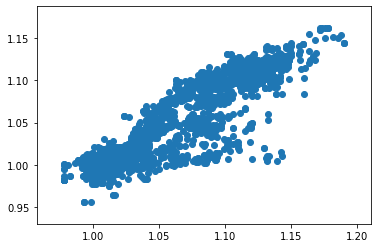

In [18]:
from sklearn import preprocessing
quantile_transformer = preprocessing.QuantileTransformer(
    output_distribution='normal', random_state=0)
X_trans = quantile_transformer.fit_transform(df)
X_trans = quantile_transformer.inverse_transform(X_trans)
# plt.plot(quantile_transformer.quantiles_)
plt.scatter(X_trans[:,0],X_trans[:,1])

In [19]:
df_qt =pd.DataFrame({'POI1': X_trans[:, 0], 'POI4': X_trans[:, 1]},index =x_date) 
df_qt

,POI1,POI4
2003-01-01,NaN,NaN
2003-01-02,NaN,NaN
2003-01-03,NaN,NaN
2003-01-04,NaN,NaN
2003-01-05,NaN,NaN
...,...,...
2010-12-27,1.049628,0.995371
2010-12-28,1.065686,1.000878
2010-12-29,1.086081,1.006386
2010-12-30,1.094131,1.009612
